# Generalised Empirical Interpolation Method: sensor placement
This notebook takes the Snapshots and places the sensors using the Generalised Empirical Interpolation Method (GEIM).

Let us create the mesh from the OpenFOAM nodes and cells

In [1]:
from pyforce.tools.write_read import ReadFromOF
from utils import create_mesh_dolfinx
from IPython.display import clear_output as clc

path_snaps = '../../../Data/MSFR/'
domain, ct, ft, gdim = create_mesh_dolfinx(path_snaps+'EVOL_geom_noreflector.geo')

Info    : Reading '../../../Data/MSFR/EVOL_geom_noreflector.geo'...
Info    : Done reading '../../../Data/MSFR/EVOL_geom_noreflector.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 20%] Meshing curve 5 (Line)
Info    : [ 30%] Meshing curve 6 (Line)
Info    : [ 30%] Meshing curve 7 (Line)
Info    : [ 30%] Meshing curve 8 (Line)
Info    : [ 40%] Meshing curve 9 (Line)
Info    : [ 40%] Meshing curve 10 (Line)
Info    : [ 50%] Meshing curve 11 (Line)
Info    : [ 50%] Meshing curve 12 (Line)
Info    : [ 60%] Meshing curve 13 (Line)
Info    : [ 60%] Meshing curve 14 (Line)
Info    : [ 60%] Meshing curve 15 (Line)
Info    : [ 70%] Meshing curve 16 (Line)
Info    : [ 70%] Meshing curve 17 (Line)
Info    : [ 80%] Meshing curve 18 (Line)
Info    : [ 80%] Meshing curve 19 (Line)
Info    : [ 80%] Meshing curve 20 (Line)
Info    : [ 90%] Meshing cu

Let us import the snapshots, variable names and time

In [2]:
import numpy as np
from dolfinx.fem import (Function, FunctionSpace)
from ufl import VectorElement
from pyforce.tools.functions_list import FunctionsList

_data = np.load('Results/variables.npz', allow_pickle=True)
var_names = _data['var_names']
is_vector = _data['is_vector']

fom_times = np.load('Results/times.npz')['fom_times']

# Fun Spaces
fun_spaces = [
    FunctionSpace(domain, ("Lagrange", 1)),
    FunctionSpace(domain, VectorElement("Lagrange", domain.ufl_cell(), 1)),
    FunctionSpace(domain, ("Lagrange", 1)),
    FunctionSpace(domain, ("Lagrange", 1))
]

snaps = {
    field: FunctionsList(fun_spaces[field_i])
    for field_i, field in enumerate(var_names)
}
for field_i, field in enumerate(var_names):

    _snap = np.load('Results/'+field+'.npz', allow_pickle=True)['field']

    for tt in range(len(fom_times)):
        snaps[field].append(_snap[:,tt])

Let us define the boundary-tags at which sensors will be placed

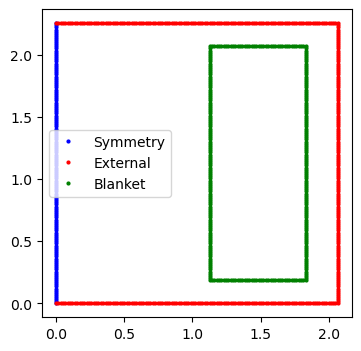

In [3]:
from dolfinx.fem import locate_dofs_topological

measured_field_i = 0

sym_bound_marker = 1
ext_bound_marker = 2
bla_bound_marker = 3

sym_tags = locate_dofs_topological(fun_spaces[measured_field_i], ft.dim, ft.find(sym_bound_marker))
ext_tags = locate_dofs_topological(fun_spaces[measured_field_i], ft.dim, ft.find(ext_bound_marker))
bla_tags = locate_dofs_topological(fun_spaces[measured_field_i], ft.dim, ft.find(bla_bound_marker))

import matplotlib.pyplot as plt

nodes = fun_spaces[measured_field_i].tabulate_dof_coordinates()

fig, axs = plt.subplots(figsize=(4, 4))
plt.plot(nodes[sym_tags, 0], nodes[sym_tags, 1], 'bo', markersize=2, label='Symmetry')
plt.plot(nodes[ext_tags, 0], nodes[ext_tags, 1], 'ro', markersize=2, label='External')
plt.plot(nodes[bla_tags, 0], nodes[bla_tags, 1], 'go', markersize=2, label='Blanket')
plt.legend()

Let us split the snapshots into train, test and predict
\begin{equation}
    \left\{
        \begin{aligned}
            \Xi_{\text{train}} &= [0:0.025:20] \setminus[0.1:0.1:20] \\
            \Xi_{\text{test}} &= [0.1:0.1:20]\\
            \Xi_{\text{predict}} &= [20:0.025:25]\\
        \end{aligned}
    \right.
\end{equation}
such that $\Xi_{\text{train}}\cap \Xi_{\text{test}}=\emptyset$.

In [4]:
Nt = len(fom_times)
cut_train = int(0.8*Nt)

train_indices = np.arange(0, cut_train)
test_indices = train_indices[3::4]
train_indices = np.delete(train_indices, test_indices)

train_snaps = FunctionsList(fun_spaces[measured_field_i])
for ii in train_indices:
    train_snaps.append(snaps[var_names[measured_field_i]](ii))

Let us define the available sensor positions. Three strategies are available:
1. No constraints (ID)
2. Constrained to the full boundary (BF)
3. Constrained to the true boundary (BP) - no symmetry

In [7]:
xm_list = {
    'ID': None,
    'BF': list(),
    'BP': list(),
}

for tag in sym_tags:
    xm_list['BF'].append(nodes[tag])
    
for tag in ext_tags:
    xm_list['BP'].append(nodes[tag])
    xm_list['BF'].append(nodes[tag])

for tag in bla_tags:
    xm_list['BP'].append(nodes[tag])
    xm_list['BF'].append(nodes[tag])

sample_every = 1
s = 0.025

## GEIM Training Phase
Let us define the training phase of the GEIM.

In [8]:
from pyforce.offline.geim import GEIM

geim_offline = {
    strategy: GEIM(domain, fun_spaces[measured_field_i], var_names[measured_field_i], s=s)
    for strategy in xm_list.keys()
}

Mmax = 40

maxAbsErr = dict()
maxRelErr = dict()
betaCoeff = dict()

print('----------------------------------------------------------------------------')
for strategy in xm_list.keys():

    print(f'Running GEIM with {strategy} strategy')
    maxAbsErr[strategy], maxRelErr[strategy], betaCoeff[strategy] = geim_offline[strategy].offline(train_snaps, Mmax = Mmax,
                                                                                                    xm=xm_list[strategy], sampleEvery=sample_every,
                                                                                                    verbose=True)
    
    print(' ')
    print('----------------------------------------------------------------------------')

----------------------------------------------------------------------------
Running GEIM with ID strategy
Generating sensors (sampled every 1 cells): 11571.000 / 11571.00 - 0.001 s/it
  Iteration 040 | Abs Err: 4.95e-01 | Rel Err: 2.55e-04
----------------------------------------------------------------------------
Running GEIM with BF strategy
Generating sensors (coinstrained cells): 800.000 / 800.00 - 0.001 s/it
  Iteration 040 | Abs Err: 9.98e+00 | Rel Err: 5.14e-03
----------------------------------------------------------------------------
Running GEIM with BP strategy
Generating sensors (coinstrained cells): 669.000 / 669.00 - 0.001 s/it
  Iteration 040 | Abs Err: 1.07e+01 | Rel Err: 5.51e-03
----------------------------------------------------------------------------


Let us plot the decrease of the training error (absolute and relative)

Text(0, 0.5, 'Max Rel. Error')

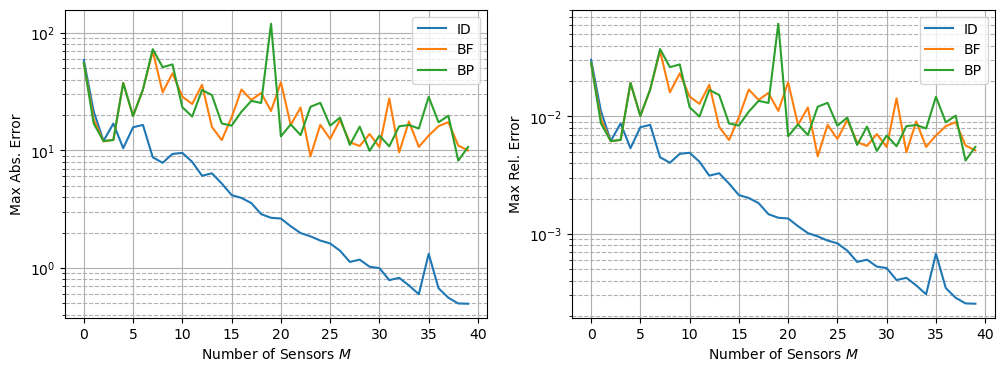

In [9]:
fig, axs = plt.subplots(1,2,figsize=(12, 4))

for strategy in xm_list.keys():
    axs[0].plot(maxAbsErr[strategy], label=strategy)
    axs[1].plot(maxRelErr[strategy], label=strategy)

for ax in axs:
    ax.set_yscale('log')
    ax.set_xlabel('Number of Sensors $M$')
    ax.legend()
    ax.grid(which='major', linestyle='-')
    ax.grid(which='minor', linestyle='--')

axs[0].set_ylabel('Max Abs. Error')
axs[1].set_ylabel('Max Rel. Error')

Let us store the magic functions and sensors and the trained reduced coefficients.

In [10]:
import os
from pyforce.tools.write_read import StoreFunctionsList

path_offline = 'Results/GEIM_offline/'
os.makedirs(path_offline, exist_ok=True)

for strategy in xm_list.keys():
    StoreFunctionsList(domain, geim_offline[strategy].magic_fun, f'GEIM_{var_names[measured_field_i]}_{strategy}_mf',
                       filename = path_offline+f'GEIM_{var_names[measured_field_i]}_{strategy}_mf')
    StoreFunctionsList(domain, geim_offline[strategy].magic_sens, f'GEIM_{var_names[measured_field_i]}_{strategy}_ms',
                       filename = path_offline+f'GEIM_{var_names[measured_field_i]}_{strategy}_ms')
    
    np.savez_compressed(path_offline+f'GEIM_{var_names[measured_field_i]}_{strategy}_TrainBeta.npz',
                        betaCoeff[strategy])

Let us plot the magic functions

[Text(0.5, 1.0, 'ID'), Text(0.5, 1.0, 'BF'), Text(0.5, 1.0, 'BP')]

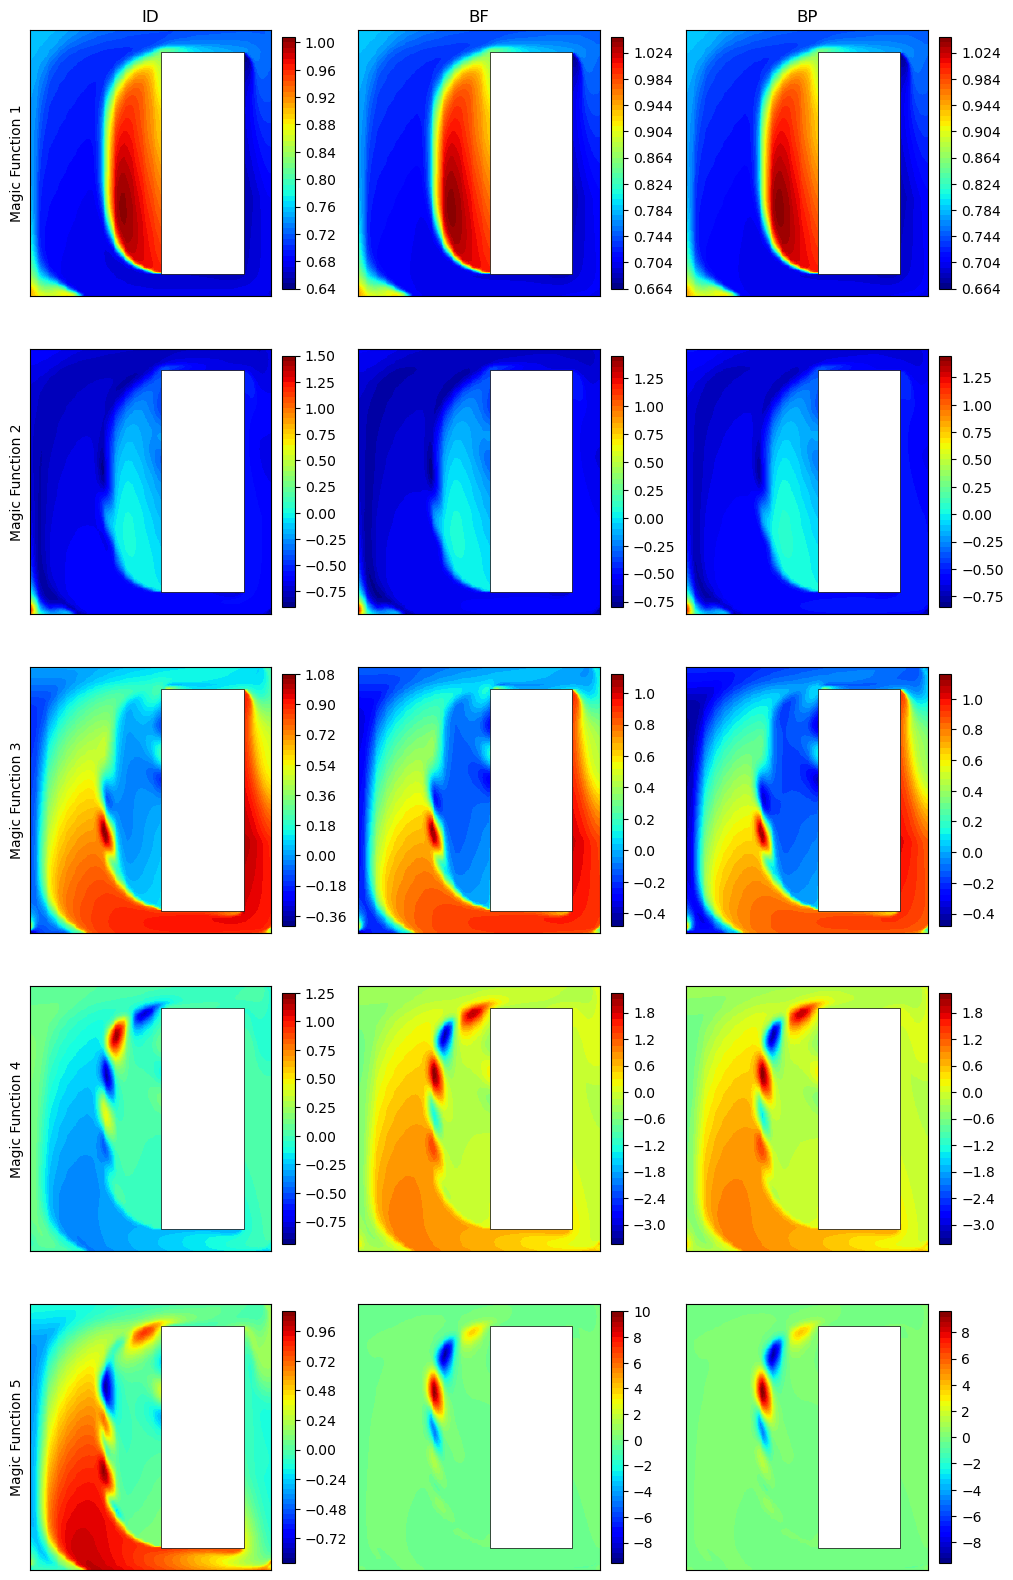

In [11]:
from utils import plot_contour

mf_to_plot = np.arange(0, 5, 1)

nrows = len(mf_to_plot)
ncols = len(xm_list.keys())

fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))

for row in range(nrows):
    for col, strategy in enumerate(xm_list.keys()):
        mf = geim_offline[strategy].magic_fun(mf_to_plot[row])
        cont = plot_contour(axs[row, col], domain.geometry.x[:, :2], mf, levels=50)
        cbar = fig.colorbar(cont, ax=axs[row, col], fraction=0.046, pad=0.04)
    axs[row, 0].set_ylabel(f'Magic Function {mf_to_plot[row]+1}')

[axs[0, col].set_title(list(xm_list.keys())[col]) for col in range(ncols)]

Let us plot the magic sensors

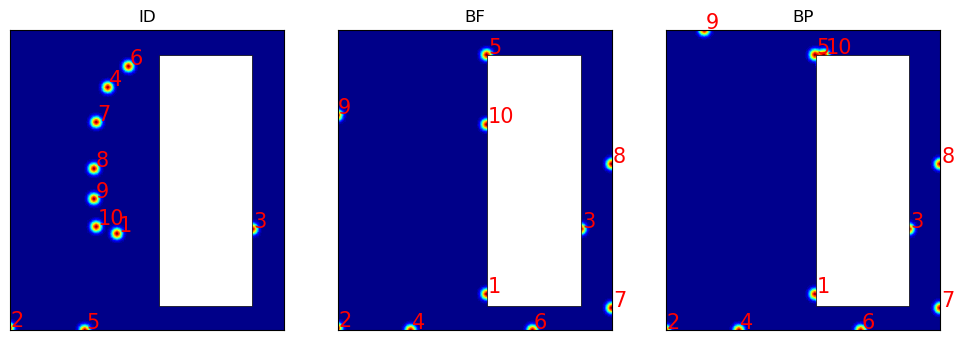

In [12]:
sens_to_plot = 10

fig, axs = plt.subplots(1, len(xm_list.keys()), figsize=(len(xm_list.keys())*4, 4))

for col, strategy in enumerate(xm_list.keys()):
    ms = np.zeros((train_snaps.fun_shape,))

    locs = list()

    for mm in range(sens_to_plot):
        ms += geim_offline[strategy].magic_sens(mm) / max(geim_offline[strategy].magic_sens(mm))
        locs.append(np.argmax(geim_offline[strategy].magic_sens(mm)))
    points = domain.geometry.x[locs, :2]
    labels = [str(mm+1) for mm in range(sens_to_plot)]
    cont = plot_contour(axs[col], domain.geometry.x[:, :2], ms, levels=50)
    axs[col].set_title(strategy)

    offset = 0.01
    for (x, y), label in zip(points, labels):
        axs[col].text(x + offset, y + offset, label, fontsize=15, color='red')


### Calculate the Lebesgue constant
Here the constant is calculated from the magic sensors and functions

In [13]:
from pyforce.offline.geim import computeLebesgue

lebesgue = dict()

for strategy in xm_list.keys():
    print(f'Computing Lebesgue constant for {strategy} strategy')
    lebesgue[strategy] = computeLebesgue(geim_offline[strategy].magic_fun, geim_offline[strategy].magic_sens)

Computing Lebesgue constant for ID strategy
Computing Lebesgue constant for BF strategy
Computing Lebesgue constant for BP strategy


Let us plot it against the number of sensors

Text(0, 0.5, 'Lebesgue constant $\\Lambda_M$')

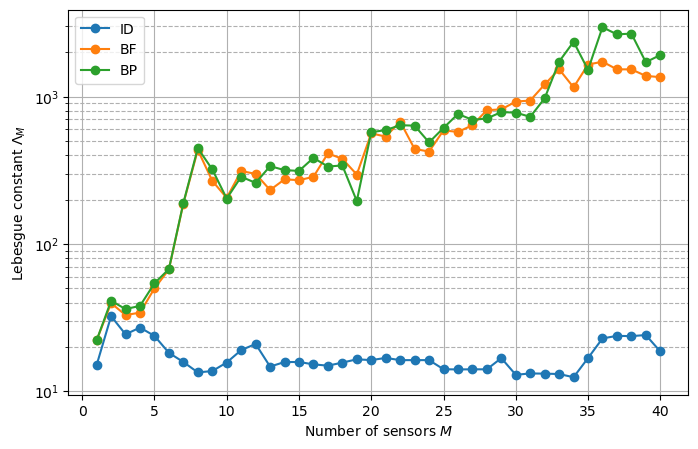

In [14]:
M_plot = np.arange(1, Mmax+1)

fig, axs = plt.subplots(figsize=(8,5))

for strategy in xm_list.keys():
    axs.plot(M_plot, lebesgue[strategy], 'o-', label=strategy)

axs.set_yscale('log')
axs.legend()
axs.grid(which='major', linestyle='-')
axs.grid(which='minor', linestyle='--')
axs.set_xlabel(r'Number of sensors $M$')
axs.set_ylabel(r'Lebesgue constant $\Lambda_M$')